In [2]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, mannwhitneyu, f_oneway, ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from statsmodels.stats.power import TTestIndPower

from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

# Не используем файл hw_abt_2_bybucket.csv, так как используем bootstrap
df = pd.read_csv('hw_abt_2_byuser.csv', sep='\t')

In [3]:
# Удаляем колонку 'Unnamed: 0', так как она полностью повторяет индексы
df.drop(columns = 'Unnamed: 0', inplace = True)
df

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B
...,...,...,...,...,...,...,...
4995,6,3666.000,1,4,1,5,A
4996,12,6464.976,0,0,1,8,B
4997,1,4335.000,0,0,0,8,A
4998,13,6307.976,0,0,1,8,B


In [18]:
# Определяем функции, которые будем использовать

# Для всех метрик будем использовать критерий Шапиро-Уилка, так как он обладает большей мощностью
def shapiro_test(series):
    st_A = shapiro(series)
    print('Distribution of values is {}normal\n'.format( {True:'not ', False:''}[st_A[1] < alpha]))

def leven_test(series_1, series_2):
    st_var = levene(series_1, series_2)
    print('Variances of distributions is {}equal\n'.format({True:'not ', False:''}[st_var[1] < alpha]))

def histograms(series_1, series_2, b=10):
    series_1.hist(alpha=0.4, weights=[1/len(series_1)]*len(series_1), bins=b, color='red')
    series_2.hist(alpha=0.4, weights=[1/len(series_2)]*len(series_2), bins=b, color='green')
    plt.axvline(series_1.mean(), color='red', alpha=1, linestyle='dashed')
    plt.axvline(series_2.mean(), color='green', alpha=1, linestyle='dashed')
    
# Функция для построения графиков, после оценки статзначимости, для наглядности
def graphs_after_test(series_1, series_2, b=10):
    series = pd.Series(bs.bootstrap_ab(series_1.values, 
                                            series_2.values, 
                                            bs_stats.mean, bs_compare.percent_change, 
                                            num_iterations=1000, alpha=0.05, 
                                            iteration_batch_size=100, scale_test_by=1,
                                            return_distribution=True))
    
    series.hist(alpha=0.4, weights=[1/len(series)]*len(series), bins=b)
    plt.axvline(series.mean(), alpha=1, linestyle='dashed')
    plt.show()
    
    series.plot.box()
    plt.show()

In [5]:
# Определяем альфу
alpha = 0.05

# Определим необходимые серии для metric_value
series_metric_value_A = df[df.group == 'A'].metric_value
series_metric_value_B = df[df.group == 'B'].metric_value

# Определим необходимые серии для users
series_users_A = df[df.group == 'A'].users
series_users_B = df[df.group == 'B'].users

# Определим необходимые серии для visits
series_visits_A = df[df.group == 'A'].visits
series_visits_B = df[df.group == 'B'].visits

# Определим необходимые серии для churn_users
series_churn_users_A = df[df.group == 'A'].churn_users
series_churn_users_B = df[df.group == 'B'].churn_users

# Определим необходимые серии для churn_visits
series_churn_visits_A = df[df.group == 'A'].churn_visits
series_churn_visits_B = df[df.group == 'B'].churn_visits

### Рассмотрим метрику metric_value

In [5]:
# Проверяем распределения на нормальность для группы А
shapiro_test(series_metric_value_A)

Distribution of values is not normal



In [6]:
# Проверяем распределения на нормальность для группы B
shapiro_test(series_metric_value_B)

Distribution of values is not normal



In [7]:
# Проводим оценку равенства дисперсий с помощью критерия Левена, так как выборки групп A и B не соответствуют 
# нормальному закону, а критерий Левена менее чувствителен к отклонению от нормального распределния
leven_test(series_metric_value_A, series_metric_value_B)

Variances of distributions is equal



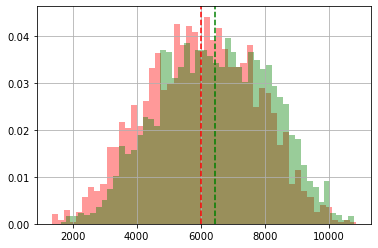

In [32]:
# Построим гистограмму до бутстрапирования
# Группа А - красный
# Группа В - зеленый
# Пунктирные линии - средние

histograms(series_metric_value_A, series_metric_value_B, 50)

In [6]:
# Оценим статистическую значимость с помощью метода bootstrap_ab

bs_ab_estims = bs.bootstrap_ab(series_metric_value_A.values, 
                               series_metric_value_B.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=1000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

-6.714434133461797    (-8.137416804039606, -5.244268148583785)

In [ ]:
# Результатом bootstrap_ab является доверительный интервал, который не содержит 0, следовательно, изменение значительно.
# Нововведение вызвало положительный эффект на метрику metric_value.

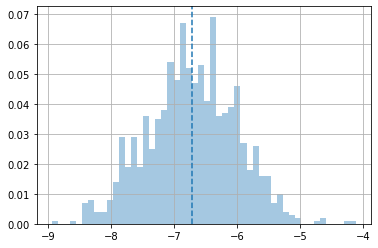

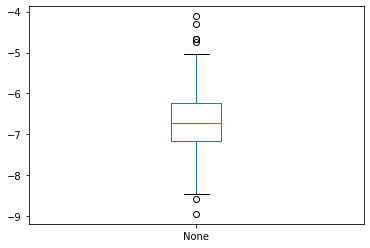

In [20]:
# Для наглядности результата построим гистограмму и диаграмму размаха

graphs_after_test(series_metric_value_A, series_metric_value_B, b=50)

### Рассмотрим метрику users

In [9]:
# Проверяем распределения на нормальность для группы А
shapiro_test(series_users_A)

Distribution of values is not normal



In [10]:
# Проверяем распределения на нормальность для группы B
shapiro_test(series_users_B)

Distribution of values is not normal



In [11]:
# Проводим оценку равенства дисперсий с помощью критерия Левена, так как выборки групп A и B не соответствуют 
# нормальному закону, а критерий Левена менее чувствителен к отклонению от нормального распределния
leven_test(series_users_A, series_users_B)

Variances of distributions is equal



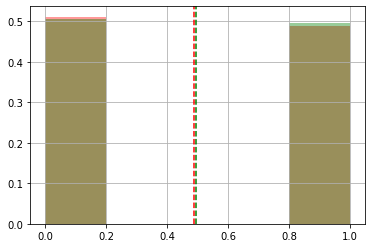

In [34]:
# Построим гистограмму до бутстрапирования
# Группа А - красный
# Группа В - зеленый
# Пунктирные линии - средние

histograms(series_users_A, series_users_B, 5)

In [44]:
# Оценим статистическую значимость с помощью метода bootstrap_ab

bs_ab_estims = bs.bootstrap_ab(series_users_A.values, 
                               series_users_B.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=5000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

-1.3581247926878777    (-7.130678058160539, 4.069038064616568)

In [ ]:
# Результатом bootstrap_ab является доверительный интервал, который содержит 0, следовательно, изменение не значительно.
# Нововведение не вызвало никакого эффекта на метрику users.

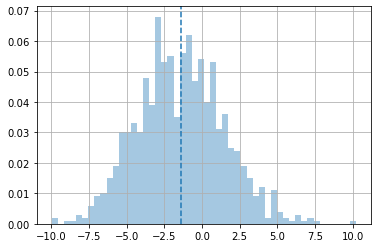

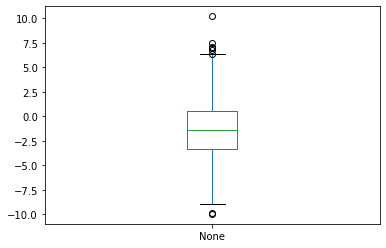

In [22]:
# Для наглядности результата построим гистограмму и диаграмму размаха

graphs_after_test(series_users_A, series_users_B, b=50)

### Рассмотрим метрику visits

In [13]:
# Проверяем распределения на нормальность для группы А
shapiro_test(series_visits_A)

Distribution of values is not normal



In [14]:
# Проверяем распределения на нормальность для группы B
shapiro_test(series_visits_B)

Distribution of values is not normal



In [15]:
# Проводим оценку равенства дисперсий с помощью критерия Левена, так как выборки групп A и B не соответствуют 
# нормальному закону, а критерий Левена менее чувствителен к отклонению от нормального распределния
leven_test(series_visits_A, series_visits_B)

Variances of distributions is equal



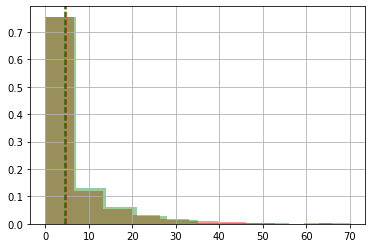

In [35]:
# Построим гистограмму до бутстрапирования
# Группа А - красный
# Группа В - зеленый
# Пунктирные линии - средние

histograms(series_visits_A, series_visits_B)

In [45]:
# Оценим статистическую значимость с помощью метода bootstrap_ab

bs_ab_estims = bs.bootstrap_ab(series_visits_A.values, 
                               series_visits_B.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=5000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

6.274004253176184    (-5.1385749299799315, 16.5563369170343)

In [ ]:
# Результатом bootstrap_ab является доверительный интервал, который содержит 0, следовательно, изменение не значительно.
# Нововведение не вызвало никакого эффекта на метрику visits.

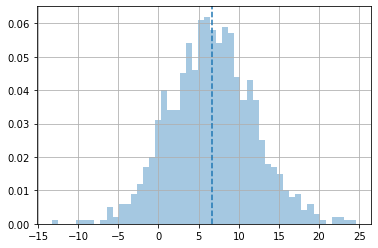

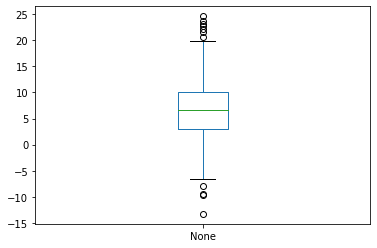

In [24]:
# Для наглядности результата построим гистограмму и диаграмму размаха

graphs_after_test(series_visits_A, series_visits_B, b=50)

### Рассмотрим метрику churn_users

In [17]:
# Проверяем распределения на нормальность для группы А
shapiro_test(series_churn_users_A)

Distribution of values is not normal



In [18]:
# Проверяем распределения на нормальность для группы B
shapiro_test(series_churn_users_B)

Distribution of values is not normal



In [19]:
# Проводим оценку равенства дисперсий с помощью критерия Левена, так как выборки групп A и B не соответствуют 
# нормальному закону, а критерий Левена менее чувствителен к отклонению от нормального распределния
leven_test(series_churn_users_A, series_churn_users_B)

Variances of distributions is not equal



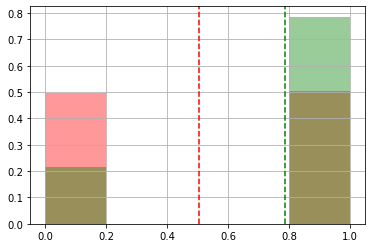

In [37]:
# Построим гистограмму до бутстрапирования
# Группа А - красный
# Группа В - зеленый
# Пунктирные линии - средние

histograms(series_churn_users_A, series_churn_users_B, 5)

In [46]:
# Оценим статистическую значимость с помощью метода bootstrap_ab

bs_ab_estims = bs.bootstrap_ab(series_churn_users_A.values, 
                               series_churn_users_B.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=5000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

-35.96108476641168    (-38.98433634151178, -33.19490846918986)

In [ ]:
# Результатом bootstrap_ab является доверительный интервал, который не содержит 0, следовательно, изменение значительно.
# Нововведение вызвало увеличение количества пользователей, отказавшихся сделать заказ.

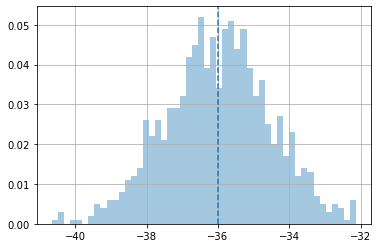

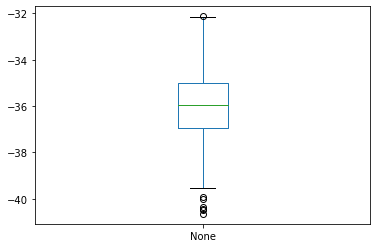

In [25]:
# Для наглядности результата построим гистограмму и диаграмму размаха

graphs_after_test(series_churn_users_A, series_churn_users_B, b=50)

### Рассмотрим  метрику churn_visits

In [21]:
# Проверяем распределения на нормальность для группы А
shapiro_test(series_churn_visits_A)

Distribution of values is not normal



In [22]:
# Проверяем распределения на нормальность для группы B
shapiro_test(series_churn_visits_B)

Distribution of values is not normal



In [23]:
# Проводим оценку равенства дисперсий с помощью критерия Левена, так как выборки групп A и B не соответствуют 
# нормальному закону, а критерий Левена менее чувствителен к отклонению от нормального распределния
leven_test(series_churn_visits_A, series_churn_visits_B)

Variances of distributions is equal



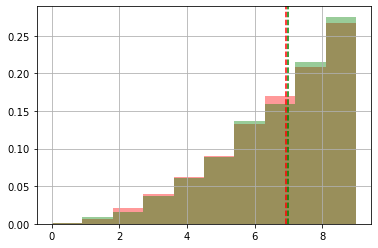

In [38]:
# Построим гистограмму до бутстрапирования
# Группа А - красный
# Группа В - зеленый
# Пунктирные линии - средние

histograms(series_churn_visits_A, series_churn_visits_B)

In [47]:
# Оценим статистическую значимость с помощью метода bootstrap_ab

bs_ab_estims = bs.bootstrap_ab(series_churn_visits_A.values, 
                               series_churn_visits_B.values, 
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=5000, alpha=0.05, 
                               iteration_batch_size=100, scale_test_by=1)

bs_ab_estims

-0.7301589201516756    (-2.245634301081687, 0.7806595524865241)

In [ ]:
# Результатом bootstrap_ab является доверительный интервал, который содержит 0, следовательно, изменение не значительно.
# Нововведение не вызвало никакого эффекта на метрику churn_visits.

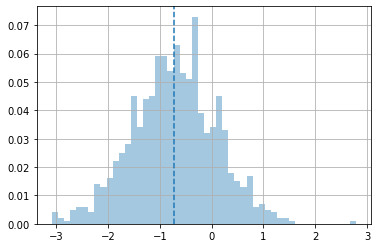

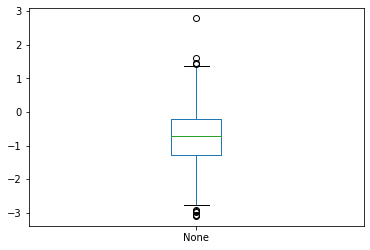

In [26]:
# Для наглядности результата построим гистограмму и диаграмму размаха

graphs_after_test(series_churn_visits_A, series_churn_visits_B, b=50)

### Заключение

Изменения не повлияли на метрики users, visits и churn_visits. В рамках эксперимента metric_value в среднем увеличилось. Также в рамках эксперимента увеличилось количество пользователей, отказавшихся сделать заказ, что сказывается отрицательно для сайта.